# Particle timestructure

For some applications it is important to consider the particle arrival time, taking the longitudinal coordinate `zeta` into account.
This includes non-circular lines, characterisation of extracted particle spills or long-term studies of coasting beams.
The particle arrival time is:

\begin{equation*}
t = \frac{\text{at_turn}}{f_\text{rev}} - \frac{\text{zeta}}{\beta_0 c_0}
\end{equation*}

where the first term is only relevant for circular lines. 

The plots in this guide are all based on the particle arrival time.

In [1]:
import xtrack as xt
import xpart as xp
import xplt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

np.random.seed(43543557)

In [2]:
## Generate a simple 6-fold symmetric FODO lattice
n = 6
elements = []
for i in range(n):
    elements.extend(
        [
            xt.Drift(length=0.7),
            xt.Multipole(length=0.3, knl=[0, +0.63], ksl=[0, 0]),
            xt.Drift(length=0.7),
            xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
            xt.Drift(length=0.4),
            # xt.Multipole(length=0.2, knl=[0, 0, 0.5 * np.sin(2 * np.pi * (i / n))]),
            xt.Drift(length=0.3),
            xt.Multipole(length=0.3, knl=[0, -0.48], ksl=[0, 0]),  # -0.4
            xt.Drift(length=0.7),
            xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
            xt.Drift(length=2.2),
        ][:: -1 if i % 2 else 1]
    )

line = xt.Line(elements=elements)

## Create the tracker
tracker = xt.Tracker(line=line)

Found suitable prebuilt kernel `default_only_xtrack`.


In [3]:
## Generate particles
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
nparticles = int(1e3)

# Transverse distribution (gaussian)
norm_emitt_x = 2e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_x)
norm_emitt_y = 1e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_y)
x, px = xp.generate_2D_gaussian(nparticles)
y, py = xp.generate_2D_gaussian(nparticles)

# Longitudinal distribution (coasting beam)
rel_momentum_spread = 1e-2  # relative momentum spread ( P/p0 - 1 )
zeta = line.get_length() * np.random.uniform(-0.5, 0.5, nparticles)
delta = rel_momentum_spread * xp.generate_2D_gaussian(nparticles)[0]

particles = xp.build_particles(
    tracker=tracker,
    particle_ref=line.particle_ref,
    x_norm=x,
    px_norm=px,
    nemitt_x=norm_emitt_x,
    y_norm=y,
    py_norm=py,
    nemitt_y=norm_emitt_y,
    method="4d",  # for twiss (default is 6d, won't work without a cavity)
    zeta=zeta,
    delta=delta,
)

In [4]:
## Twiss
tw = tracker.twiss(method="4d")

## Track
tracker.track(particles, num_turns=100, turn_by_turn_monitor=True)

In [5]:
## Generate dummy spill data
n = int(1e6)
spill = {"t": np.random.uniform(1, 4, n) + np.random.gumbel(0, 0.1, n)}

## Scatter over time

The `TimePlot` allows to plot any particle property as function of time

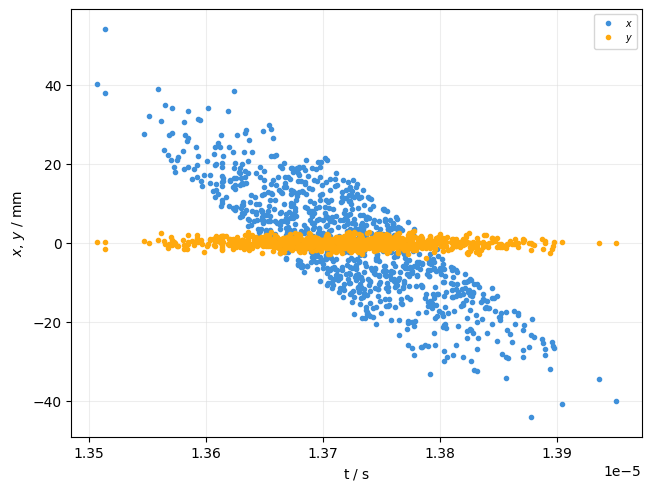

In [6]:
plot = xplt.TimePlot(particles, "x+y", twiss=tw)

## Binned time series

The `TimeBinPlot` allows to plot particle counts or averaged properties as time series with a given resolution.  
Thereby all particles arriving within the interval defined by the time resolution are counted or averaged over.

The time resolution can be given with the `bin_time` keyword argument.

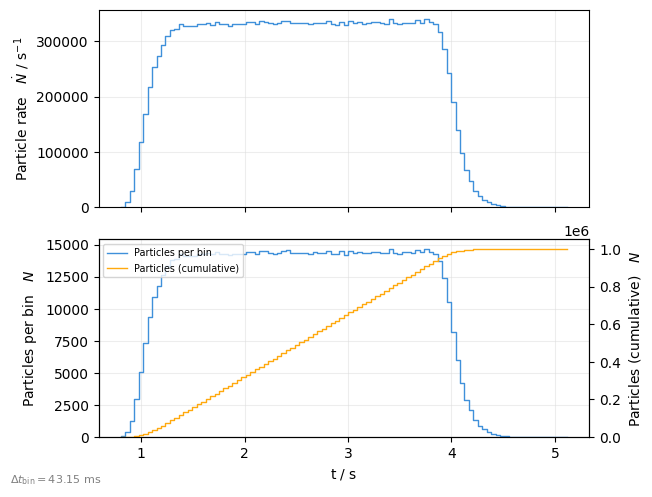

In [7]:
# Spill intensity: plot number of lost particles as function of time
plot = xplt.TimeBinPlot(spill, "rate,count-cumulative", twiss=tw)

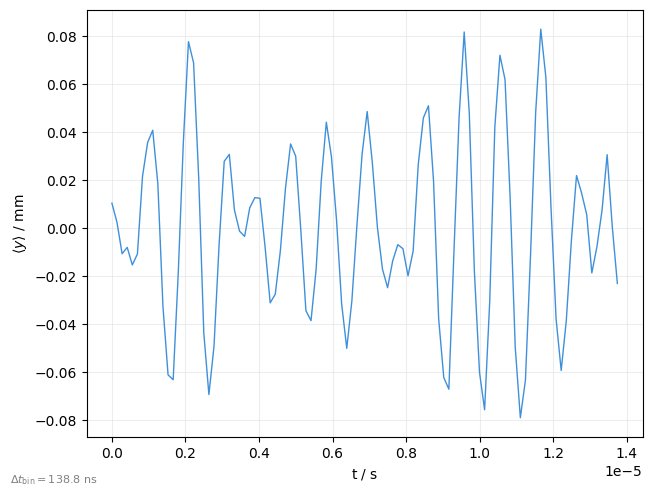

In [8]:
# Beam position monitor: plot average y as function of time
plot = xplt.TimeBinPlot(tracker.record_last_track, "y", twiss=tw)

### Count variations

The following metrices exists to quantify the fluctuation of particle numbers in the respective bins:
- `cv`: Coefficient of variation
- `duty`: Spill duty factor
- `maxmean`: Maximum to mean ratio

These are useful to assess the spill quality.

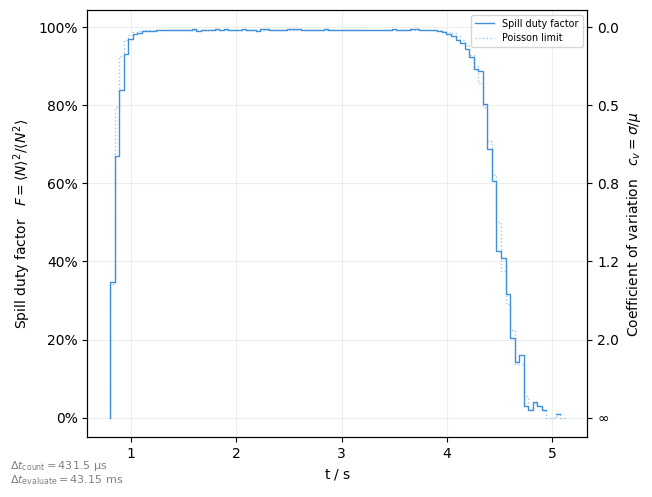

In [15]:
# Plot a metric as function of time in the spill
plot = xplt.TimeVariationPlot(
    spill,
    "duty",
    twiss=tw,
    counting_dt=None,  # bin time for particle counting (detector resolution)
    evaluate_dt=None,  # bin time to evaluate metric
)

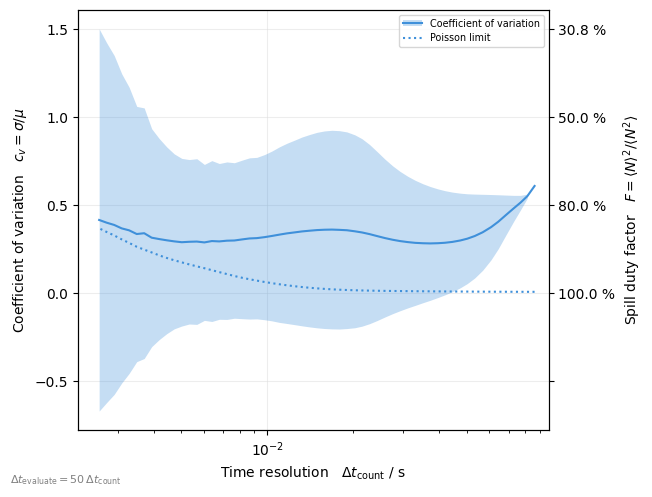

In [16]:
# Plot a metric as function of timescale (counting bin time)
plot = xplt.TimeVariationScalePlot(spill, "cv", twiss=tw)

## Consecutive particle delay

The `TimeIntervalPlot` allows analysis of the delay between consecutive particles.

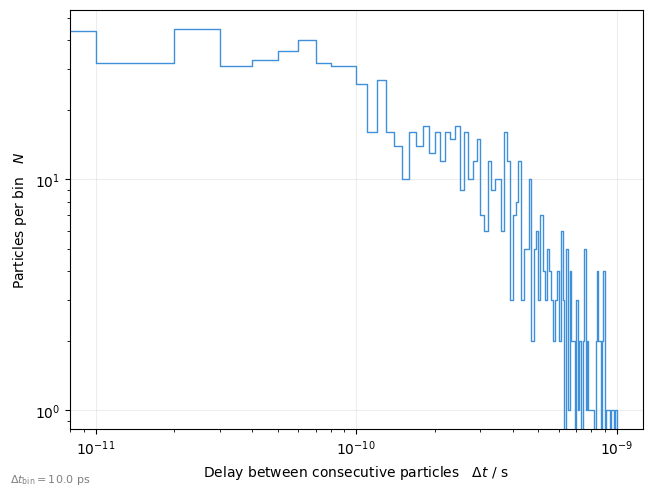

In [11]:
plot = xplt.TimeIntervalPlot(particles, tmax=1e-9, log=True, twiss=tw)

## Frequency domain

The `TimeFFTPlot` allows frequency analysis of particle data. Therefore the data is first binned into an equidistant time series as described above, and then an FFT is performed. This allows to plot the frequency spectrum of particle arrival time:

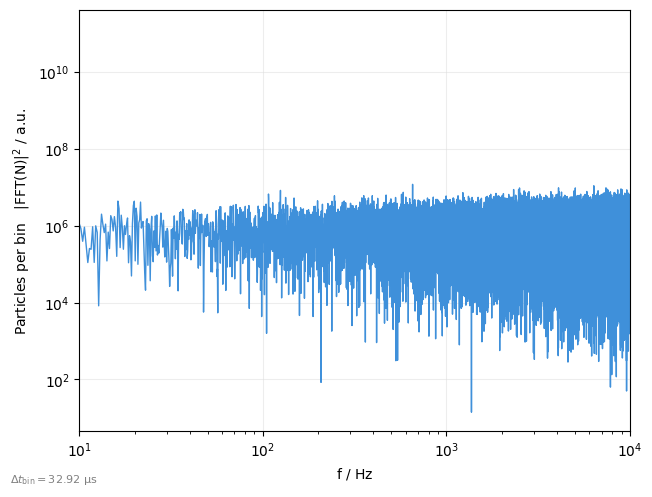

In [12]:
plot = xplt.TimeFFTPlot(spill, fmax=1e4, log=True, twiss=tw)

### Tune spectrum

Simmilary, the frequency spectrum of transverse motion (betatron tune spectrum) can be plotted. Note that the spectrum is based on transverse position as function of time and not as function of turn (this gives access to frequencies above half the revolution frequency).

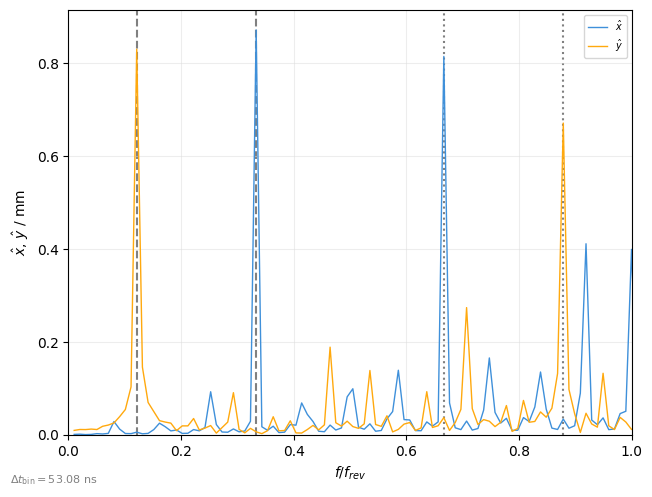

In [13]:
mask = (
    0,
    None,
)  # select only a single particle, otherwise the tune signal is very small due to insufficient coherence of our beam

plot = xplt.TimeFFTPlot(tracker.record_last_track, "x+y", relative=True, mask=mask, twiss=tw)

for Q in (tw.qx, tw.qy):
    q, h = np.modf(Q)
    plot.ax.axvline(0 + q, ls="--", color="gray", zorder=-1)
    plot.ax.axvline(1 - q, ls=":", color="gray", zorder=-1)

For reference, the spectrum of turn-by-turn positions:

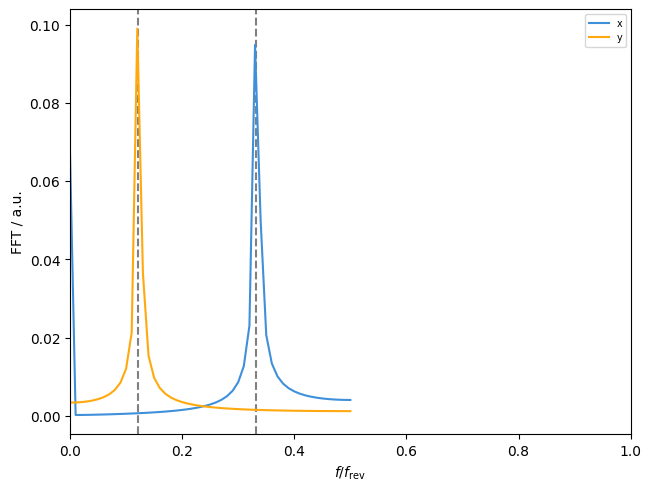

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
for xy in "xy":
    p = getattr(tracker.record_last_track, xy)[0, :]
    freq = np.fft.rfftfreq(len(p))
    mag = np.abs(np.fft.rfft(p))
    ax.plot(freq, mag, label=xy)
    ax.axvline(np.modf(getattr(tw, "q" + xy))[0], ls="--", color="gray", zorder=-1)
ax.legend()
ax.set(xlabel="$f/f_\\mathrm{rev}$", ylabel="FFT / a.u.", xlim=(0, 1));

------------
```{seealso}
- {class}`xplt.timestructure`
```